In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import csc_matrix, diags
from scipy.sparse.linalg import eigs
from numpy import linalg as LA
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time
from optimparallel import minimize_parallel

In [1]:
def FlipFlop(n, i, j):
    v = list(format(n, '0{}b'.format(L)))
    if (v[i] != '0' and v[j] != '1'):
        v[i] = '0'
        v[j] = '1'
        return int(''.join(v), 2)
    else:
        return -1
        
def Raise(n, i):
    v = list(format(n, '0{}b'.format(L)))
    # checking mod here, unsure why since accesses aren't modded
    if (v[i] != '1'):
        v[i] = '1'
        return int(''.join(v), 2)
    else:
        return -1

In [3]:
L = 4
Sz = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        sprs[j, j] = 2*int(format(j, '0{}b'.format(L))[i])-1
    Sz.append(sprs)
SzTot = sum(Sz)

Sp = []
for i in range(L):
    sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
    for j in range(2**L):
        h = Raise(j, i)
        if (h != -1):
            sprs[h, j] = 1
    Sp.append(sprs)

Heis = []
for i in range(L):
    _ = []
    for k in range(L):
        sprs = csc_matrix((2**L, 2**L), dtype=np.int8)
        for j in range(2**L):
            h = FlipFlop(j, i, k)
            v = lambda i: 2*int(format(j, '0{}b'.format(L))[i])-1 
            if (h != -1):
                sprs[j, h] = 2
                sprs[h, j] = 2
            sprs[j, j] = v(i) * v(k)
        _.append(sprs)    
    Heis.append(_)

Sm = [Sp[i].T for i in range(L)]
Sx = [Sp[i]+Sm[i] for i in range(L)]
Sy = [-1j*Sz[i] @ Sx[i] for i in range(L)]
SxTot = sum(Sx)
SyTot = sum(Sy)

C:\Users\nfber\anaconda3\envs\qc\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


# Exact time evolution

In [4]:
H = sum([Heis[i][(i+1)%L] for i in range(L)]) / 4
# H = (sum([Heis[i][(i+1)%L] for i in range(L)]) + sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)])) / 4 # H plus Z_i Z_{i+2}
# Hzzz = (sum([Heis[i][(i+1)%L] for i in range(L)]) + sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) + sum([diags(Heis[i][(i+3)%L].diagonal()) for i in range(L)])) / 4
# e, v = eigs(H, 30)

# ind = e.argsort()
# e = e[idx]
# v = v[:, idx]
# np.conj(v.T) @ H @ v - np.diag(e), decimals=3)

In [5]:
H.toarray()

array([[ 1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0.5,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0.5,  0. , -1. ,  0.5,  0. ,  0. ,  0.5,  0. ,
         0. ,  0.5,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0.5,
         0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0.5,  0. ,  0. ,  0.5,  0. ],
       [ 0. ,  0.5,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
         0. ,  0. ,  0

In [6]:
tf = 25
dt = tf / 200
Nt = int(tf / dt)
c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
UnitVector = lambda c: np.eye(2**L)[c-1]
init = UnitVector(int(''.join(c), 2))

In [7]:
revos = [np.zeros(2**L) for i in range(Nt+1)]
revos[0] = init
for i in range(Nt):
    # scipy.sparse.linalg.expm_multiply
    revos[i+1] = expm(-1j * H * dt) @ revos[i]

In [8]:
Szt = []
for i in range(len(revos)):
    Szt.append(np.conj(revos[i]) @ (Sz[0]) @ revos[i] / 2)

C:\Users\nfber\anaconda3\envs\qc\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


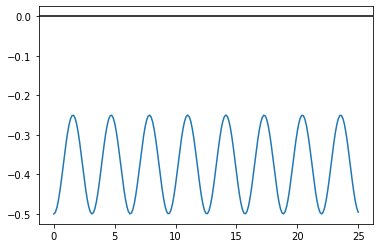

In [9]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.axhline(y=0, color='k')

# Trotter Evolution

In [10]:
def TrotterEvolve(tf, nt, init):
    dt = tf / nt
    UOdd = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(0, L, 2)]) / 4) # since Python indices start at 0, this is actually even
    UEven = expm(-1j * dt * sum([Heis[i][(i+1)%L] for i in range(1, L, 2)]) / 4) # since Python indices start at 0, this is actually the odd indices
    UZ = expm(-1j * dt * sum([diags(Heis[i][(i+2)%L].diagonal()) for i in range(L)]) / 2)
    UTrotter = UEven @ UOdd @ UZ
    # UTrotter = UEven @ UOdd
    psi_trot = init
    for i in range(nt):
        psi_trot = UTrotter @ psi_trot
    return psi_trot

In [13]:
TrotterFixStepList = [init]
for i in range(Nt):
    TrotterFixStepList.append(TrotterEvolve((i+1)*dt, 1, init))
TrotterFixStepSz = []
for i in range(len(TrotterFixStepList)):
    TrotterFixStepSz.append(np.conj(TrotterFixStepList[i]) @ Sz[0] @ TrotterFixStepList[i] / 2)

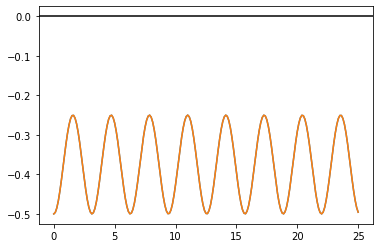

In [14]:
plt.plot([i*dt for i in range(len(revos))], Szt)
plt.plot([i*dt for i in range(len(TrotterFixStepList))], TrotterFixStepSz)
plt.axhline(y=0, color='k')

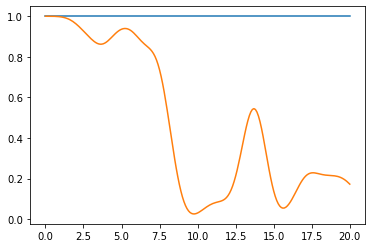

In [105]:
ExFidelity = [abs(np.conj(revos[i]) @ revos[i])**2 for i in range(len(revos))]
VTDFidelity = [abs(np.conj(revos[i]) @ TrotterFixStepList[i])**2 for i in range(len(TrotterFixStepList))]
plt.plot([i*dt for i in range(len(revos))], ExFidelity)
plt.plot([i*dt for i in range(len(TrotterFixStepList))], VTDFidelity)

# Ansatz

In [10]:
p = 1
def Ansatz(params):
    # check for correct length of params
    psi_ansz = init
    for i in range(p): # len(params) // L
        for j in range(0, L, 2):
            # odd first, then even. Apply to left
            psi_ansz = expm(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
        for j in range(1, L, 2):
            psi_ansz = expm(-1j * params[(L*i)+j] * Heis[j][(j+1)%L]) @ psi_ansz
        # for j in range(L):
        #     psi_ansz = expm(-1j * params[(2*L*i)+L+j] * diags(Heis[j][(j+2)%L].diagonal()).tocsc()) @ psi_ansz
    return psi_ansz

def Loss(x, target, O):
    psi_ansz = Ansatz(x)
    Sz_ansz = np.conj(psi_ansz) @ (O) @ psi_ansz / 2
    Sz_ex = np.conj(target) @ (O) @ target / 2
    return abs(Sz_ansz - Sz_ex)

def Fidelity(x, target):
    psi_ansz = Ansatz(x)
    return 1 - abs(np.conj(target) @ psi_ansz)**2

In [11]:
# VarSzList = []
# params = []
# params.append(np.random.uniform(0, 2*np.pi, L*p))
# for i in range(1, len(revos)+1):
#     sol = minimize(fun=Loss, x0=params[i-1], args=(revos[i-1], Sz[0]-Sz[1]+Sz[2]-Sz[3]), method='SLSQP')
#     params.append(sol.x)
#     bar = Ansatz(sol.x)
#     VarSzList.append(np.conj(bar) @ Sz[0] @ bar / 2)

#     if (i % 10 == 0):
#         print(i)

In [12]:
# plt.plot([i*dt for i in range(len(revos))], Szt, label='Exact')
# # plt.plot([i*dt for i in range(len(TrotterFixStepList))], TrotterFixStepSz)
# plt.plot([i*dt for i in range(len(VarSzList))], VarSzList, label='Ansatz p=1')
# plt.legend()
# plt.axhline(y=0, color='k')

In [17]:
init_params = np.random.uniform(0, np.pi, L*p)
O = Sz[0]-Sz[1]+Sz[2]-Sz[3]
ind = 4
start = time.time()
# sol = minimize(fun=Loss, x0=init_params, args=(revos[ind], O), method='L-BFGS-B')
sol = minimize(fun=Fidelity, x0=init_params, args=(revos[ind]), method='L-BFGS-B')

# sol = minimize_parallel(fun=Loss, x0=init_params, args=revos[-1], parallel={'loginfo': True})
end = time.time()
print(end - start)
print(sol)
print(repr(sol.x))

13.572630643844604
      fun: 0.047299474150480636
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.22124533e-06, -4.55191443e-06, -1.33226764e-07, -4.41868766e-06,
       -6.69464484e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 168
      nit: 15
     njev: 28
   status: 0
  success: True
        x: array([0.21476252, 1.79828598, 2.93908549, 1.83515746, 0.21690803])
array([0.21476252, 1.79828598, 2.93908549, 1.83515746, 0.21690803])


In [33]:
psi = Ansatz(sol.x)
# ev_psi = Ansatz([1.76723, 2.32244, 0.0496827, 1.81951, 2.22329])
print(np.conj(psi) @ O @ psi / 2)
print(np.conj(revos[ind]) @ O @ revos[ind] / 2)
# print(np.conj(ev_psi) @ O @ ev_psi / 2)
print(psi)

(-0.9999999999999429+0j)
-1.0
[ 0.00000000e+00+0.00000000e+00j  2.89233293e-02+9.99581633e-01j
 -1.35561007e-07+9.81987847e-09j  0.00000000e+00+0.00000000e+00j
 -4.26305329e-10-5.88504021e-09j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -1.00842218e-07+2.91791345e-09j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


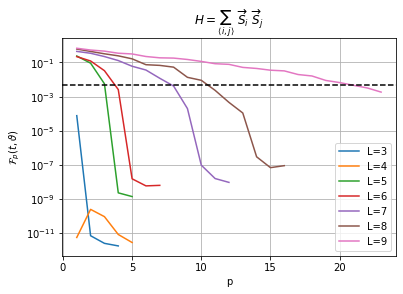

In [2]:
Ls = [[7.628298041963965e-05, 7.115508182664599e-12, 2.549849220656597e-12, 1.8034018722801193e-12],
     [5.62875301923782e-12,  2.486457040262735e-10, 9.333963602031758e-11, 8.425871111938932e-12, 2.856304082143879e-12],
     [0.23740583985079872,  0.09018143303410489, 0.005630595118117938, 2.306564717002857e-09, 1.3992125902362317e-09],   
     [0.21821515736153224, 0.12117207266992884,  0.032803823376721296, 0.0025723319313157742, 1.5313387402571265e-08, 5.903220134939602e-09, 6.335558078163217e-09],
     [0.4416971453768938, 0.34299320384153126, 0.22001574619512673, 0.12844234779741895, 0.05962808328780318, 0.035828445509600716, 0.011771594826817111,  0.004130638042409207,  0.00019832176531731083,  9.665429889782473e-08, 1.5870017522345847e-08, 9.458759331337774e-09],
     [0.6056825526205183, 0.438986601838685, 0.3193890360989698,  0.2425347989227742, 0.16197830129699997, 0.07344478982751768, 0.066922248587858, 0.05276029556729145, 0.013381105199347432, 0.00896657503515308, 0.002310166409083547, 0.00045735592659534863, 0.00010921068541902557, 2.9730262285365683e-07, 6.897986482012897e-08, 9.003292145148833e-08],
     [0.6750787364173185, 0.530680420755301, 0.45735440289247686, 0.34511543046386195, 0.3125376803388209, 0.22174826552906213, 0.18542487903302407, 0.17885545432756755, 0.14845909180398975, 0.11433048717285754, 0.08389648975101716, 0.07697281787855204, 0.05106172867892089, 0.04424654711679288, 0.03498580927868111, 0.03188829944091931, 0.019497839935901262, 0.01605811444620464, 0.008795035405009477, 0.006602343638761776, 0.00456348055081246, 0.00319472835241863, 0.001826113132404327]]
# L10 = [0.6369274620479408, 0.5224910459936618, 0.4797445893373805, 0.3436969438668106, 0.2975110350752568, 0.28952671496855387, 0.25106137841898446]
# L11 = [0.7884947125456306, 0.6862101064288398, 0.5347413862950722]

fig, ax = plt.subplots(1, 1)
for i in range(len(Ls)):
    plt.plot(np.array([j for j in range(1, len(Ls[i])+1)]), Ls[i], label=f"L={i+3}")

plt.axhline(5e-3, color='k', linestyle='--')
plt.ylabel('$\mathcal{F}_p (t, \\vartheta)$')
plt.title('$H = \sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j$')
# plt.ylabel('$1 - | \langle \psi (t) | \Phi_p(\\vartheta) \\rangle |$')
plt.xlabel('p')
plt.grid(True)
plt.legend(loc='lower right')
plt.yscale('log')
# plt.savefig('p_vs_fidelity', dpi=300, transparent=False, bbox_inches='tight')


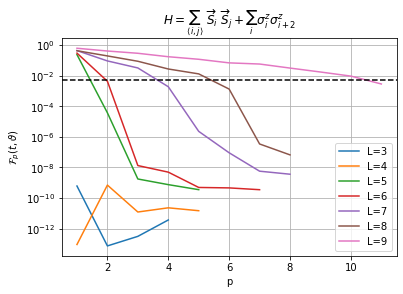

In [2]:
Ls = [[6.114742046037236e-10, 7.4495964952348e-14, 3.1386004906153175e-13, 3.690492356156483e-12],
     [9.214851104388799e-14, 7.0277594854673e-10, 1.2255751968837103e-11, 2.301248080982532e-11, 1.488287271200761e-11],
     [0.23587715643681584, 3.712555606805168e-05, 1.7615657821323794e-09, 7.533523804781339e-10, 3.5280933730064135e-10],
     [0.2960697609192007, 0.004285426297938488, 1.328714993586999e-08, 4.9360884268878635e-09, 4.923137453261006e-10, 4.607062509265347e-10, 3.516218427535023e-10],
     [0.43352702995732884, 0.09139558137145898, 0.031780922718279925, 0.0018843402542104704, 2.279320281628472e-06, 9.080644292058793e-08, 5.695784288661798e-09, 3.610365117978631e-09],
     [0.4246863136581852, 0.1941407133634797, 0.08688578040138895, 0.02716324455276231, 0.01300091676908055, 0.0013228943780155822, 3.4229136902652613e-07, 6.618561976257098e-08],
     [0.6162652995381064, 0.4058944468391801, 0.2887999501478785, 0.17208523437036505, 0.11704438874212209, 0.06820022715456797, 0.05726284610142873, 0.031178403910421815, 0.017252464987339122, 0.00931616069436958, 0.0028456772892193616]]

fig, ax = plt.subplots(1, 1)
for i in range(len(Ls)):
    plt.plot(np.array([j for j in range(1, len(Ls[i])+1)]), Ls[i], label=f"L={i+3}")

plt.axhline(5e-3, color='k', linestyle='--')
plt.title('$H = \sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j + \sum_i \sigma_i^z \sigma_{i+2}^z $')
plt.ylabel('$\mathcal{F}_p (t, \\vartheta)$')
# plt.ylabel('$1 - | \langle \psi (t) | \Phi_p(\\vartheta) \\rangle |$')
plt.xlabel('p')
plt.grid(True)
plt.legend(loc='lower right')
plt.yscale('log')

# plt.xlim([0,11])
# plt.savefig('p_vs_fidelityHz', dpi=300, transparent=False, bbox_inches='tight')


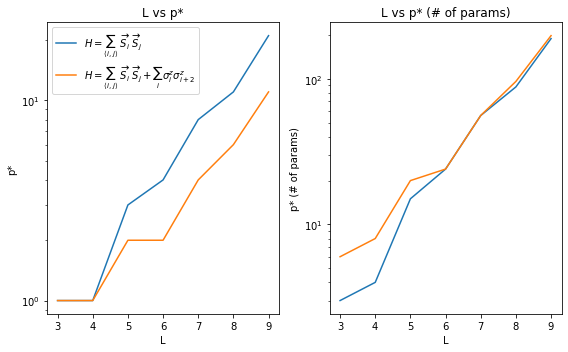

In [4]:
LstarH = np.array([1, 1, 3, 4, 8, 11, 21])
L = np.array([3, 4, 5, 6, 7, 8, 9])
LstarHparams = np.multiply(LstarH, L)
LHz = np.array([3, 4, 5, 6, 7, 8, 9])
LstarHz = np.array([1, 1, 2, 2, 4, 6, 11])
LstarHzparams = np.multiply(LstarHz*2, LHz)
fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].set(ylabel='p*', xlabel='L', title='L vs p*')
# ax[0].title('L vs p* for Heisenberg models')
ax[0].semilogy(L, LstarH, label='$H = \sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j$')
ax[0].semilogy(LHz, LstarHz, label='$H = \sum_{\langle i, j \\rangle} \ \overrightarrow{S}_i \ \overrightarrow{S}_j + \sum_i \sigma_i^z \sigma_{i+2}^z $')
ax[1].semilogy(L, LstarHparams)
ax[1].semilogy(LHz, LstarHzparams)
ax[1].set(ylabel='p* (# of params)', xlabel='L', title='L vs p* (# of params)')

ax[0].legend(loc='upper left')
fig.tight_layout()

plt.savefig('L_vs_pstar', dpi=300, transparent=False, bbox_inches='tight')


Text(0.5, 0, 't')

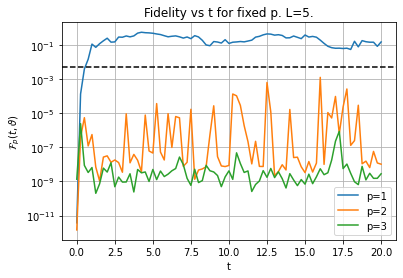

In [3]:
datas = [pd.read_csv(f'results_5/results_5_{i+1}.txt', sep=',', header=None) for i in range(3)]
for i in range(len(datas)):
    plt.plot(datas[i][1], datas[i][0], label=f'p={i+1}')
plt.yscale('log')
plt.axhline(5e-3, color='k', linestyle='--')
plt.grid(True)
plt.legend(loc='lower right')
plt.ylabel('$\mathcal{F}_p (t, \\vartheta)$')
plt.title('Fidelity vs t for fixed p. L=5.')
plt.xlabel('t')

Text(0.5, 0, 't')

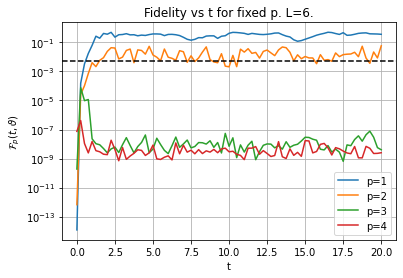

In [4]:
datas = [pd.read_csv(f'results_6/results_6_{i+1}.txt', sep=',', header=None) for i in range(4)]
for i in range(len(datas)):
    plt.plot(datas[i][1], datas[i][0], label=f'p={i+1}')
plt.yscale('log')
plt.grid(True)
plt.axhline(5e-3, color='k', linestyle='--')
plt.legend(loc='lower right')
plt.ylabel('$\mathcal{F}_p (t, \\vartheta)$')
plt.title('Fidelity vs t for fixed p. L=6.')
plt.xlabel('t')

Text(0.5, 0, 't')

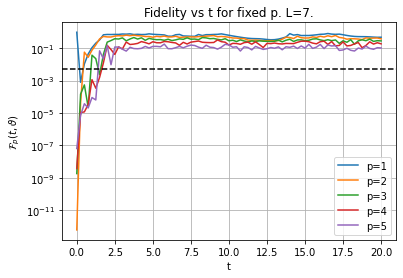

In [24]:
datas = [pd.read_csv(f'results_7/results_7_{i+1}.txt', sep=',', header=None) for i in range(5)]
for i in range(len(datas)):
    plt.plot(datas[i][1], datas[i][0], label=f'p={i+1}')
plt.yscale('log')
plt.grid(True)
plt.axhline(5e-3, color='k', linestyle='--')
plt.legend(loc='lower right')
plt.ylabel('$\mathcal{F}_p (t, \\vartheta)$')
plt.title('Fidelity vs t for fixed p. L=7.')
plt.xlabel('t')